# VGG16

In [17]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import pylab as pl
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import KFold

import cv2
import random
from PIL import Image
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
import tensorflow as tf
from tensorflow import keras

import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

print(tf.__version__)

2.4.1


## Preprocess Adience Dataset

In [4]:
#load data
ADIENCE_PATH = './Adience'
print(os.listdir(path=ADIENCE_PATH))

all_folds={}
for i in range(5):
    all_folds[i]=pd.read_csv(os.path.join(ADIENCE_PATH, f'fold_{i}_data.txt'),sep = "\t" )

['AdienceBenchmarkGenderAndAgeClassification', 'faces', 'fold_0_data.txt', 'fold_1_data.txt', 'fold_2_data.txt', 'fold_3_data.txt', 'fold_4_data.txt', '__MACOSX']


In [5]:
total_data = pd.concat([all_folds[i] for i in range(5)],ignore_index=True)
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19370 entries, 0 to 19369
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             19370 non-null  object
 1   original_image      19370 non-null  object
 2   face_id             19370 non-null  int64 
 3   age                 19370 non-null  object
 4   gender              18591 non-null  object
 5   x                   19370 non-null  int64 
 6   y                   19370 non-null  int64 
 7   dx                  19370 non-null  int64 
 8   dy                  19370 non-null  int64 
 9   tilt_ang            19370 non-null  int64 
 10  fiducial_yaw_angle  19370 non-null  int64 
 11  fiducial_score      19370 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.8+ MB


In [6]:
total_data.head()

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34


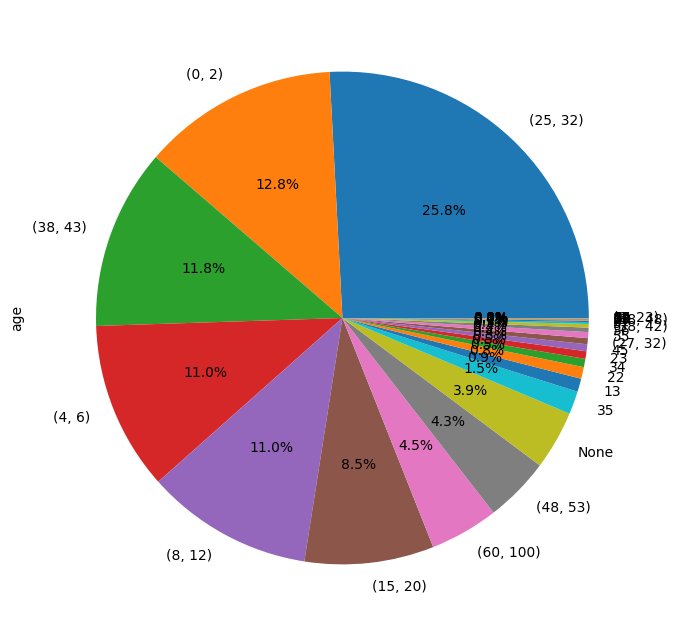

In [7]:
#pie_graph
plt.figure(1, figsize=(8,8))
total_data.age.value_counts().plot.pie(autopct="%1.1f%%")
plt.show()

f    9372
m    8120
u    1099
Name: gender, dtype: int64


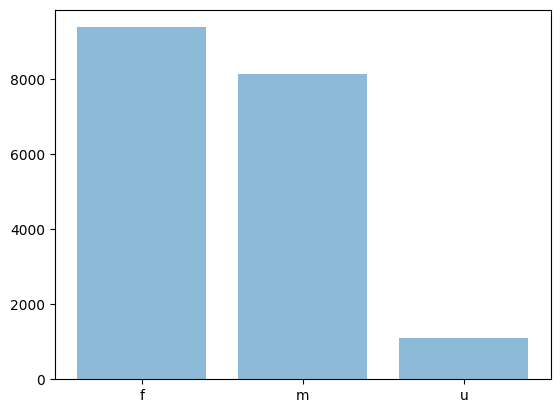

In [8]:
#bar chart
gender = ['f','m','u']
plt.bar(gender, total_data.gender.value_counts(), align='center', alpha=0.5)
print(total_data.gender.value_counts())
plt.show()

In [9]:
df = total_data[['age', 'gender', 'x', 'y', 'dx', 'dy']].copy()

img_path = []

for row in total_data.iterrows():
    path = f"{ADIENCE_PATH}/faces/"+row[1].user_id+"/coarse_tilt_aligned_face."+str(row[1].face_id)+"."+row[1].original_image
    img_path.append(path)
df['img_path'] = img_path

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19370 entries, 0 to 19369
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       19370 non-null  object
 1   gender    18591 non-null  object
 2   x         19370 non-null  int64 
 3   y         19370 non-null  int64 
 4   dx        19370 non-null  int64 
 5   dy        19370 non-null  int64 
 6   img_path  19370 non-null  object
dtypes: int64(4), object(3)
memory usage: 1.0+ MB


In [10]:
age_mapping = [('(0, 2)', '0-2'), ('2', '0-2'), ('3', '0-2'), ('(4, 6)', '4-6'), ('(8, 12)', '8-13'), ('13', '8-13'), ('22', '15-20'), ('(8, 23)','15-20'), ('23', '25-32'), ('(15, 20)', '15-20'), ('(25, 32)', '25-32'), ('(27, 32)', '25-32'), ('32', '25-32'), ('34', '25-32'), ('29', '25-32'), ('(38, 42)', '38-43'), ('35', '38-43'), ('36', '38-43'), ('42', '48-53'), ('45', '38-43'), ('(38, 43)', '38-43'), ('(38, 42)', '38-43'), ('(38, 48)', '48-53'), ('46', '48-53'), ('(48, 53)', '48-53'), ('55', '48-53'), ('56', '48-53'), ('(60, 100)', '60+'), ('57', '60+'), ('58', '60+')]

age_mapping_dict = {each[0]: each[1] for each in age_mapping}
drop_labels = []
for idx, each in enumerate(df.age):
    if each == 'None':
        drop_labels.append(idx)
    else:
        df.age.loc[idx] = age_mapping_dict[each]

df = df.drop(labels=drop_labels, axis=0) #droped None values
df.age.value_counts(dropna=False)


/tmp/ipykernel_6260/3196150795.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = age_mapping_dict[each]


25-32    5296
38-43    2776
0-2      2509
8-13     2292
4-6      2140
15-20    1792
48-53     916
60+       901
Name: age, dtype: int64

In [11]:
df = df.dropna()
unbiased_data = df[df.gender != 'u'].copy()
unbiased_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17452 entries, 0 to 19345
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       17452 non-null  object
 1   gender    17452 non-null  object
 2   x         17452 non-null  int64 
 3   y         17452 non-null  int64 
 4   dx        17452 non-null  int64 
 5   dy        17452 non-null  int64 
 6   img_path  17452 non-null  object
dtypes: int64(4), object(3)
memory usage: 1.1+ MB


In [12]:
gender_to_label_map = {
    'f' : 0,
    'm' : 1
}

age_to_label_map = {
    '0-2'  :0,
    '4-6'  :1,
    '8-13' :2,
    '15-20':3,
    '25-32':4,
    '38-43':5,
    '48-53':6,
    '60+'  :7
}

# label_to_age_map = {value: key for key, value in age_to_label_map.items()}
# label_to_gender_map = {value: key for key, value in gender_to_label_map.items()}

unbiased_data['age'] = unbiased_data['age'].apply(lambda age: age_to_label_map[age])
unbiased_data['gender'] = unbiased_data['gender'].apply(lambda g: gender_to_label_map[g])

unbiased_data.head()

,age,gender,x,y,dx,dy,img_path
0,4,0,0,414,1086,1383,./Adience/faces/30601258@N03/coarse_tilt_align...
1,4,1,301,105,640,641,./Adience/faces/30601258@N03/coarse_tilt_align...
2,4,0,2395,876,771,771,./Adience/faces/30601258@N03/coarse_tilt_align...
3,4,1,752,1255,484,485,./Adience/faces/30601258@N03/coarse_tilt_align...
4,4,1,175,80,769,768,./Adience/faces/30601258@N03/coarse_tilt_align...


### create dataset

In [13]:
X = unbiased_data[['img_path']]
y = unbiased_data[['gender']]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('Train data shape {}'.format(X_train.shape))
print('Test data shape {}'.format(X_test.shape))

Train data shape (12216, 1)
Test data shape (5236, 1)


In [14]:
train_images = []
test_images = []

for row in X_train.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((227, 227))   # Resize the image
    data = np.asarray(image)
    train_images.append(data)

for row in X_test.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((227, 227))  # Resize the image
    data = np.asarray(image)
    test_images.append(data)

train_images = np.asarray(train_images)
test_images = np.asarray(test_images)

print('Train images shape {}'.format(train_images.shape))
print('Test images shape {}'.format(test_images.shape))

Train images shape (12216, 227, 227, 3)
Test images shape (5236, 227, 227, 3)


## Create Model

### VGG16+CNN

In [15]:
batch_size=32
epochs=20
target_size = (227,227) # (64, 64)
input_shape= (227,227,3) #(64, 64, 3)

# random seed
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

adam = 0.001
fre= -20
FC = 2048
E = 1
patience = 3
verbose = 1
factor = 0.50
min_lr = 0.0001
steps_per_epoch=256
validation_steps=256

In [16]:
# VGG with imagenet pretraining
base_model = tf.keras.applications.VGG16(input_shape=input_shape, 
                                         include_top=False, weights="imagenet")
base_model.trainable = False

2022-11-09 18:13:25.724291: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-09 18:13:25.724888: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-11-09 18:13:25.772740: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 18:13:25.773154: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-11-09 18:13:25.773205: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node ze

58892288/58889256 [==============================] - 6s 0us/step


In [18]:
# Building Model
model=Sequential()
model.add(base_model)
model.add(layers.Dropout(.2))

model.add(Conv2D(512, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(128, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(384, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(384, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(500, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,strides=(2,2), padding='same'))



# Add new layers
model.add(GlobalAveragePooling2D())
model.add(Dense(FC , activation='relu'))
model.add(layers.Dropout(.2))
model.add(Dense(FC , activation='relu'))
model.add(layers.Dropout(.2))
model.add(Dense(FC, activation='relu'))
model.add(layers.Dropout(.2))
model.add(Dense(E, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 512)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 7, 7, 512)         2359808   
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 512)         2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 512)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         589952    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         5

In [19]:
# training
model.compile(optimizer=Adam(adam),
              loss='binary_crossentropy'
              ,metrics=['accuracy'])
## can try two entropies
# model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
# history = model.fit(train_images, y_train, batch_size=32, epochs=5, validation_data=(test_images, y_test), callbacks=[callback])

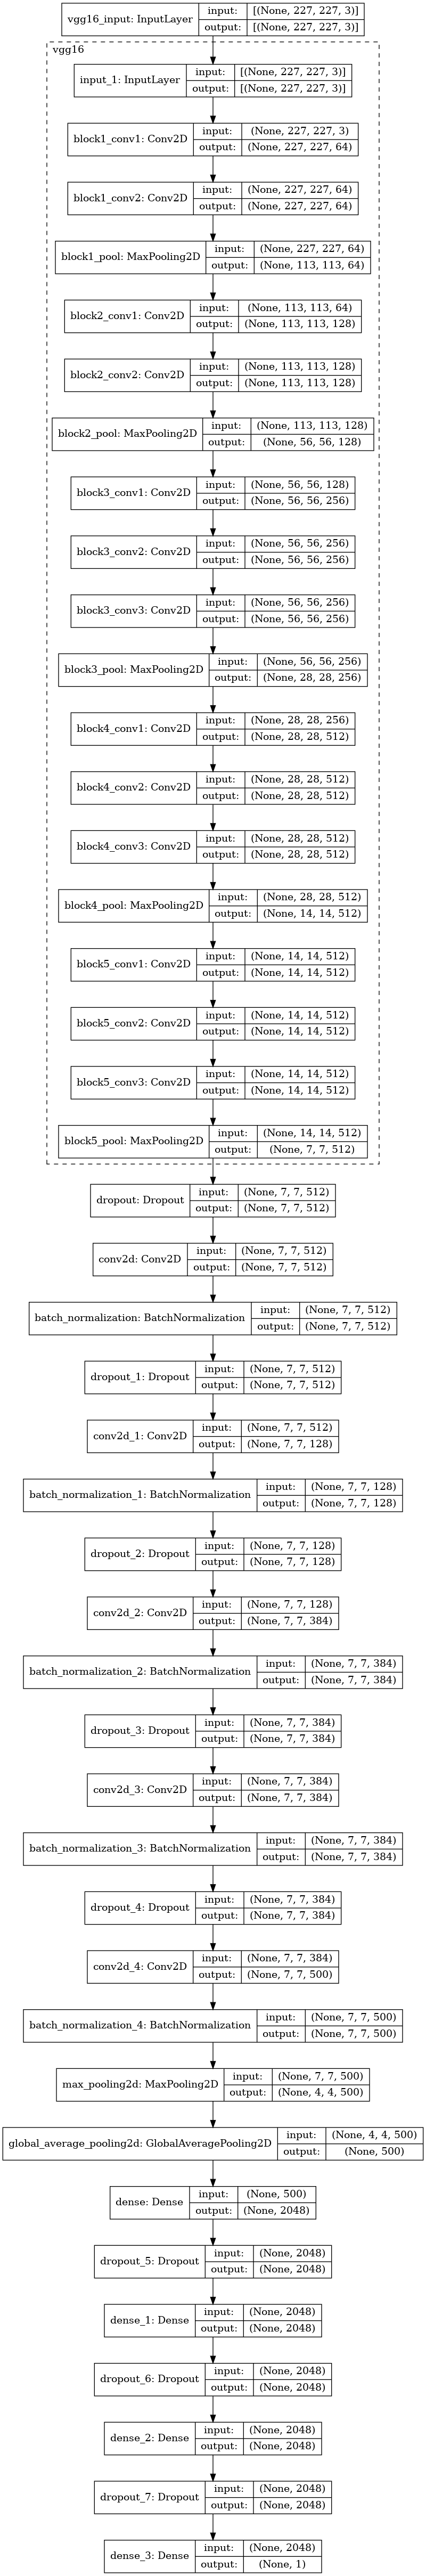

In [20]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)


In [21]:
def get_call_backs():
    lrd = ReduceLROnPlateau(monitor = 'val_loss',
                            patience = patience,
                            verbose = verbose ,
                            factor = factor,
                            min_lr = min_lr)

    mcp = ModelCheckpoint('vgg_model.h5')

    es = EarlyStopping(verbose=verbose, patience=patience)
    return [lrd, mcp, es]

In [22]:
history = model.fit(train_images, 
                    y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=(test_images, y_test), 
                    callbacks=get_call_backs())

2022-11-09 18:17:10.618040: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1888434792 exceeds 10% of free system memory.
2022-11-09 18:17:11.153633: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-11-09 18:17:11.172855: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3099995000 Hz


Epoch 1/20


2022-11-09 18:17:11.834870: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-11-09 18:17:11.957286: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-11-09 18:17:12.603494: W tensorflow/stream_executor/gpu/asm_compiler.cc:98] *** WARNING *** You are using ptxas 9.1.108, which is older than 9.2.88. ptxas 9.x before 9.2.88 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You do not need to update to CUDA 9.2.88; cherry-picking the ptxas binary is sufficient.
2022-11-09 18:17:12.699367: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:17:12.699454: W tensorflow/str

2022-11-09 18:17:15.271221: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:17:15.379056: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:17:15.476156: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:17:15.588789: W tensorflow/stream_executor/gpu/

2022-11-09 18:17:18.243422: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:17:18.339554: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:17:18.451073: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:17:18.546938: W tensorflow/stream_executor/gpu/

2022-11-09 18:17:20.962832: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:17:21.064572: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:17:21.161952: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:17:21.276611: W tensorflow/stream_executor/gpu/

2022-11-09 18:17:23.810753: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:17:23.910423: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:17:24.008111: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:17:24.116352: W tensorflow/stream_executor/gpu/

2022-11-09 18:17:26.597955: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:17:26.695716: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:17:26.792859: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:17:26.892225: W tensorflow/stream_executor/gpu/

2022-11-09 18:17:29.245883: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:17:29.343645: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:17:29.442134: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:17:29.540017: W tensorflow/stream_executor/gpu/

2022-11-09 18:17:31.903138: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:17:32.005312: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:17:32.102922: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:17:32.201508: W tensorflow/stream_executor/gpu/

2022-11-09 18:17:34.560863: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:17:34.658027: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:17:34.756712: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:17:34.854025: W tensorflow/stream_executor/gpu/

2022-11-09 18:17:37.207953: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:17:37.305468: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:17:37.402484: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:17:37.501118: W tensorflow/stream_executor/gpu/

2022-11-09 18:17:39.846790: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:17:39.943868: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:17:40.041445: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:17:40.138680: W tensorflow/stream_executor/gpu/

  4/382 [..............................] - ETA: 22s - loss: 2.5813 - accuracy: 0.4993  

2022-11-09 18:17:41.900295: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'



381/382 [============================>.] - ETA: 0s - loss: 0.6560 - accuracy: 0.7534

2022-11-09 18:18:03.325216: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:03.423498: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:03.525516: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:03.625281: W tensorflow/stream_executor/gpu/

2022-11-09 18:18:06.129104: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:06.242714: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:06.341294: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:06.446009: W tensorflow/stream_executor/gpu/

2022-11-09 18:18:09.104850: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:09.215355: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:09.312759: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:09.415537: W tensorflow/stream_executor/gpu/

2022-11-09 18:18:11.966486: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:12.079468: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:12.177428: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:12.283584: W tensorflow/stream_executor/gpu/

2022-11-09 18:18:14.842824: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:14.951251: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:15.049953: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:15.154625: W tensorflow/stream_executor/gpu/

2022-11-09 18:18:17.666617: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:17.766310: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:17.864582: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:17.963681: W tensorflow/stream_executor/gpu/

2022-11-09 18:18:20.333502: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:20.431848: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:20.531011: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:20.629497: W tensorflow/stream_executor/gpu/

2022-11-09 18:18:23.221864: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:23.449055: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:23.551043: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:23.651646: W tensorflow/stream_executor/gpu/

2022-11-09 18:18:26.049970: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:26.149352: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:26.249215: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:26.351053: W tensorflow/stream_executor/gpu/

2022-11-09 18:18:28.742279: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:28.841359: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:28.939903: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:29.039545: W tensorflow/stream_executor/gpu/

2022-11-09 18:18:31.415841: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:31.512824: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:31.611722: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:31.709263: W tensorflow/stream_executor/gpu/

382/382 [==============================] - ETA: 0s - loss: 0.6555 - accuracy: 0.7535

2022-11-09 18:18:32.895028: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:32.993060: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:33.090625: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:33.533298: W tensorflow/core/framework/cpu_a

2022-11-09 18:18:44.372650: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:44.481374: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:44.581047: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:44.690627: W tensorflow/stream_executor/gpu/

2022-11-09 18:18:47.300128: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:47.406036: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:47.505957: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:47.611621: W tensorflow/stream_executor/gpu/

2022-11-09 18:18:50.204535: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:50.309901: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:50.410005: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:50.514027: W tensorflow/stream_executor/gpu/

2022-11-09 18:18:52.993464: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:53.092373: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:53.198787: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:53.301084: W tensorflow/stream_executor/gpu/

2022-11-09 18:18:55.756157: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:55.858004: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:55.961304: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:56.067497: W tensorflow/stream_executor/gpu/

2022-11-09 18:18:58.670931: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:58.770109: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:58.872232: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:18:58.971668: W tensorflow/stream_executor/gpu/

2022-11-09 18:19:01.470663: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:19:01.570003: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:19:01.674679: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-09 18:19:01.773963: W tensorflow/stream_executor/gpu/

382/382 [==============================] - 111s 210ms/step - loss: 0.6549 - accuracy: 0.7537 - val_loss: 0.4847 - val_accuracy: 0.8165


2022-11-09 18:19:01.974624: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'



Epoch 2/20
382/382 [==============================] - 30s 78ms/step - loss: 0.2987 - accuracy: 0.8777 - val_loss: 0.3035 - val_accuracy: 0.8921
Epoch 3/20
382/382 [==============================] - 30s 79ms/step - loss: 0.2057 - accuracy: 0.9220 - val_loss: 0.3191 - val_accuracy: 0.8871
Epoch 4/20
382/382 [==============================] - 31s 80ms/step - loss: 0.1377 - accuracy: 0.9500 - val_loss: 0.3124 - val_accuracy: 0.9055
Epoch 5/20
382/382 [==============================] - 31s 81ms/step - loss: 0.1006 - accuracy: 0.9641 - val_loss: 0.4319 - val_accuracy: 0.8971

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 00005: early stopping


In [23]:
test_loss, test_acc = model.evaluate(test_images, y_test, verbose=2)
print(test_acc)

2022-11-09 18:22:01.576953: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 809417532 exceeds 10% of free system memory.


164/164 - 8s - loss: 0.4319 - accuracy: 0.8971
0.8970588445663452
